In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 

import tensorflow as tf 
import keras 
from keras import layers
df = pd.read_csv("../datasets/Task_1/7.csv")
df.head()
X = df.drop(["Price","ID"], axis=1)
y = df["Price"]

In [16]:
correlations = df.corr(numeric_only=True)
correlations

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Airbags
ID,1.00,0.00,-0.00,0.01,0.09,-0.00,-0.00,0.01,0.00,0.01,0.00,0.00,-0.00,-0.01
Price,0.00,1.00,0.07,-0.07,-0.02,0.31,-0.05,0.10,0.00,-0.02,0.01,-0.06,-0.02,-0.13
Levy,-0.00,0.07,1.00,-0.13,-0.15,0.38,-0.09,0.01,0.15,-0.03,0.27,-0.37,-0.18,0.13
Manufacturer,0.01,-0.07,-0.13,1.00,0.36,-0.21,-0.01,0.04,-0.01,0.03,-0.01,0.15,-0.03,-0.01
Model,0.09,-0.02,-0.15,0.36,1.00,-0.24,0.09,-0.01,0.01,0.00,0.12,0.22,0.03,0.03
Prod. year,-0.00,0.31,0.38,-0.21,-0.24,1.00,-0.13,-0.05,-0.00,-0.07,-0.13,-0.52,-0.10,0.20
Category,-0.00,-0.05,-0.09,-0.01,0.09,-0.13,1.00,0.08,-0.00,-0.00,-0.10,0.14,0.32,-0.01
Fuel type,0.01,0.10,0.01,0.04,-0.01,-0.05,0.08,1.00,0.04,0.02,0.01,-0.01,0.04,-0.19
Engine volume,0.00,0.00,0.15,-0.01,0.01,-0.00,-0.00,0.04,1.00,-0.00,0.11,-0.02,-0.03,0.03
Mileage,0.01,-0.02,-0.03,0.03,0.00,-0.07,-0.00,0.02,-0.00,1.00,-0.00,0.05,0.01,-0.01


In [17]:
#this doesnt finish for some reason, just runs forever

#from skfeature.function.similarity_based import fisher_score

# get the fisher's score rankings 
#ranks = fisher_score.fisher_score(X.values, y.values)

# create a pandas DataFrame for easier interpretation
#feat_importances = pd.Series(ranks, X.columns)
#feat_importances.plot(kind='barh')

# how to interpret -> low score means the effect of this field is not large in the dataset
# => typically means other columns in the dataset have similar correlations, 
# therefore making this particular column not so useful since other columns 
# already fill this role for this correlation

# Fisher's score studies the variance of the data -> statistical significance'

# based on Fisher's score:
# num_rooms is not important at all, and num_people has minor importance in this data
# but ave_monthly_income is quite powerful based on Fisher's score

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on target variable
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
7,Mileage,2257073608170.39
0,Levy,1953331.78
2,Model,1320713.98
1,Manufacturer,18387.91
11,Airbags,12591.47
4,Category,5519.98
6,Engine volume,5432.57
9,Gear box type,2438.48
5,Fuel type,2332.67
8,Cylinders,1210.18


In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

# step 2, split the temporary data in HALF (0.5) => 15% test and 15% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [20]:
# create neural network

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# save the amount of support variables into a helper variable
# so we don't have to update the input_shape all the time
variable_amount = len(X.columns)

# create callbacks and place them into a parameter list
# NOTE! if you get PermissionError while training the model,
# just try training it again
mc = ModelCheckpoint('best_model_regression1_cars.keras', monitor='val_loss', mode='min', save_best_only=True)

# if you use multiple callbacks (EarlyStoppin, ReduceLROnPlateau etc.)
# add them to this same list
callback_list = [mc]

# let's try some common optimization approaches

# neural networks often need at least a normalization layer
# so that it updates all weight values fairly 
# typically the original dataset has various scales of numbers
# which confuses neural network while it's training itself
# luckily we have the BatchNormalization -layer in keras!

# regularization is often beneficial in neural networks
# but it's usually better to apply this a bit later
# once you know approximately a working neural network structure for your data
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dropout(0.1),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:
#####################################################################################
# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

/home/lukas/dev/venvs/DL/lib/python3.12/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,081 (47.19 KB)

 Trainable params: 12,057 (47.10 KB)

 Non-trainable params: 24 (96.00 B)

In [21]:
model.fit(x=X_train, y=y_train, epochs=1200, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 327226464.0000 - val_loss: 4222249216.0000
Epoch 2/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 168601328.0000 - val_loss: 175424464.0000
Epoch 3/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160882320.0000 - val_loss: 171103840.0000
Epoch 4/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156993328.0000 - val_loss: 168094880.0000
Epoch 5/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 155395760.0000 - val_loss: 165523760.0000
Epoch 6/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151386768.0000 - val_loss: 165549760.0000
Epoch 7/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148214192.0000 - val_loss: 164161520.0000
Epoch 8/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148949712.0000 - val_loss: 162863088.0000
Epoch 9/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 145751120.0000 - val_loss: 160957792.0000
Epoch 10/1200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss

<Axes: >

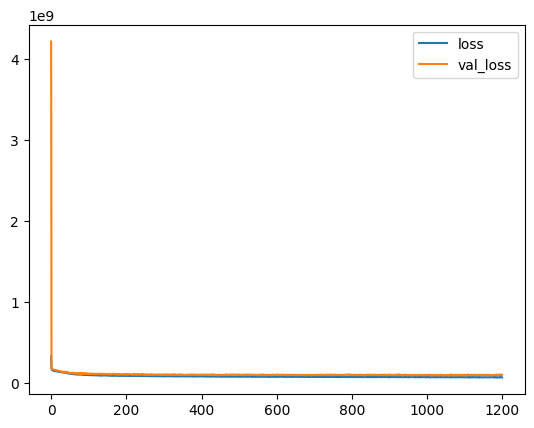

In [22]:
# let's use pandas for this (easy code)
# try to look if the model is actually training 
# => the error is going downwards
# if using validation data, you get two lines
# in this case, see if the lines follow a similar trend 
# (they don't always overlap with complex data, the trend is more important)
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [23]:
from keras.models import load_model
model = load_model("best_model_regression1_cars.keras")

In [24]:
# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
619149696.0

Train data evaluation:
189098336.0


In [25]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Test True Y,Model Predictions
0,11604,23016.74
1,9252,13474.16
2,18033,20114.81
3,25139,33191.42
4,17876,17304.29
...,...,...
2445,392,5411.65
2446,392,6391.83
2447,14426,14987.31
2448,9408,20715.10


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

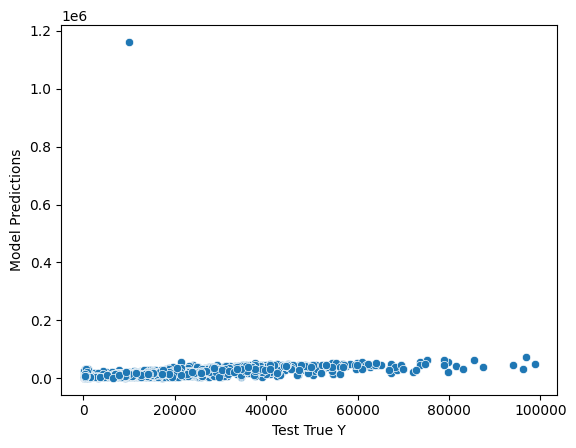

In [26]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [27]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
6262.7 $

MSE
619149504.0 $^2

RMSE:
24882.71 $

R-squared:
-1.84

Explained variance score:
-1.84


/tmp/ipykernel_821097/3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


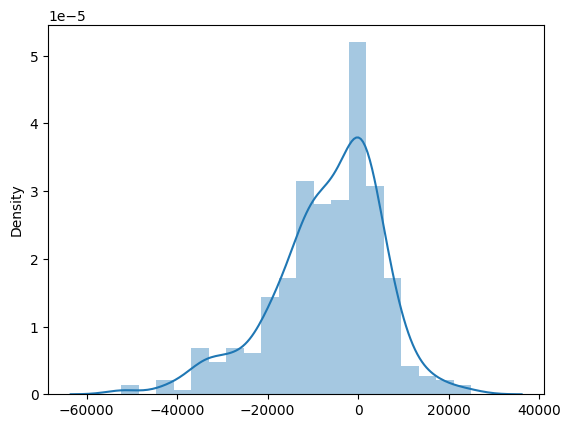

In [28]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

In [53]:
# Test a new entry: VW Polo
tester_row = {
    'Levy': 0, 
    'Manufacturer': 12, 
    'Model': 315, 
    'Prod. year': 2025,
    'Category': 3, 
    'Fuel type': 2, 
    'Engine volume': 2.0, 
    'Mileage': 0,
    'Cylinders': 4.0,
    'Gear box type': 4,
    'Drive wheels': 3,
    'Airbags': 5
}

tester_row = pd.DataFrame([tester_row])

In [54]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated car price with this example:")
print(f"$ {round(float(result[0]), 2)}")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Estimated car price with this example:
$ 48209.86
----------------
